## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

## Loading Dataset

In [ ]:
# news_name = 'PolitiFact'
news_name = 'BuzzFeed'
real_news_path = f'real_news_content.csv'
fake_news_path = f'fake_news_content.csv'

In [3]:
df_real=pd.read_csv(real_news_path)

In [4]:
df_real.shape

(91, 12)

In [5]:
df_fake=pd.read_csv(fake_news_path)

In [6]:
df_fake.shape

(91, 12)

In [7]:
df=pd.concat([df_real,df_fake],axis=0)

In [8]:
df.shape

(182, 12)

In [9]:
df['news_type']=df['id'].apply(lambda x: x.split('_')[0])

In [10]:
df['news_type'].value_counts()

Real    91
Fake    91
Name: news_type, dtype: int64

In [11]:
df.head(2)

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_type
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",Real
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",Real


In [12]:
df.shape

(182, 13)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 90
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              182 non-null    object
 1   title           182 non-null    object
 2   text            182 non-null    object
 3   url             174 non-null    object
 4   top_img         172 non-null    object
 5   authors         141 non-null    object
 6   source          174 non-null    object
 7   publish_date    133 non-null    object
 8   movies          25 non-null     object
 9   images          172 non-null    object
 10  canonical_link  170 non-null    object
 11  meta_data       182 non-null    object
 12  news_type       182 non-null    object
dtypes: object(13)
memory usage: 19.9+ KB


In [14]:
df.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_type
count,182,182,182,174,172,141,174,133,25,172,170,182,182
unique,182,178,178,171,166,90,28,118,25,169,168,171,2
top,Fake_36-Webpage,Clinton Foundation Spent 5.7% on Charity; Rest...,We’re shocked — SHOCKED — to learn that CNN’s ...,http://eaglerising.com/36847/clinton-foundatio...,http://static.politico.com/da/f5/44342c424c68b...,Terresa Monroe-hamilton,http://politi.co,{'$date': 1474588800000},https://www.youtube.com/embed/ThwaDSaoGU8?feat...,http://static.politico.com/da/f5/44342c424c68b...,http://eaglerising.com/36847/clinton-foundatio...,{},Real
freq,1,2,2,2,3,8,32,5,1,2,2,8,91


## Data Cleaning and Feature Engineering

In [15]:
df.iloc[:,[0,1,6,12]]

,id,title,source,news_type
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,http://eaglerising.com,Real
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",http://abcn.ws,Real
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com,Real
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,http://politi.co,Real
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",http://abcn.ws,Real
...,...,...,...,...
86,Fake_88-Webpage,Hillary’s TOP Donor Country Just Auctioned Off...,http://rightwingnews.com,Fake
87,Fake_89-Webpage,Cavuto Just Exposed Lester Holt's Lies During ...,http://conservativetribune.com,Fake
88,Fake_9-Webpage,"The AP, In 2004, Said Your Boy Obama Was BORN ...",http://clashdaily.com,Fake
89,Fake_90-Webpage,People Noticed Something Odd About Hillary's O...,http://www.thepoliticalinsider.com,Fake


In [16]:
df[["source", "title"]]

,source,title
0,http://eaglerising.com,Another Terrorist Attack in NYC…Why Are we STI...
1,http://abcn.ws,"Donald Trump: Drugs a 'Very, Very Big Factor' ..."
2,http://rightwingnews.com,"Obama To UN: ‘Giving Up Liberty, Enhances Secu..."
3,http://politi.co,Trump vs. Clinton: A Fundamental Clash over Ho...
4,http://abcn.ws,"President Obama Vetoes 9/11 Victims Bill, Sett..."
...,...,...
86,http://rightwingnews.com,Hillary’s TOP Donor Country Just Auctioned Off...
87,http://conservativetribune.com,Cavuto Just Exposed Lester Holt's Lies During ...
88,http://clashdaily.com,"The AP, In 2004, Said Your Boy Obama Was BORN ..."
89,http://www.thepoliticalinsider.com,People Noticed Something Odd About Hillary's O...


In [17]:
df["source"].value_counts()

http://politi.co                      32
http://rightwingnews.com              24
http://cnn.it                         23
http://eaglerising.com                18
http://freedomdaily.com               17
http://abcn.ws                         9
http://occupydemocrats.com             7
http://www.addictinginfo.org           6
https://goo.gl                         3
http://www.thepoliticalinsider.com     3
http://addictinginfo.org               3
http://winningdemocrats.com            3
http://conservativetribune.com         2
http://conservativebyte.com            2
http://www.proudcons.com               2
http://www.ifyouonlynews.com           2
http://usherald.com                    2
https://ihavethetruth.com              2
http://allenwestrepublic.com           2
http://theblacksphere.net              2
http://100percentfedup.com             2
http://clashdaily.com                  2
https://www.washingtonpost.com         1
http://www.chicksontheright.com        1
http://author.ad

In [18]:
df["title"].value_counts()

Clinton Foundation Spent 5.7% on Charity; Rest Went to “Salaries” and “Other Expenses” – Eagle Rising    2
CNN’s Post-Debate Rigged Poll Busted…Here Are The Real Results                                           2
Website is Down For Maintenance                                                                          2
A Hillary Clinton Administration May be Entirely Run by a FIGUREHEAD – Eagle Rising                      2
“Why Aren’t I 50 Points Ahead?” – Eagle Rising                                                           1
                                                                                                        ..
Debate Commission STUNS Journalists By Siding With Trump: Fact Checking Is Out Of Bounds (VIDEO)         1
SICK! Muslim Refugee Beats, Urinates On Pregnant Woman After Seeing What She Has ⋆ Freedom Daily         1
Donald Trump Goes Off The Deep End–May Be Unfit For Debate ‹ Opposition Report                           1
'Reporters' FLEE When Clintons Get EX

In [19]:
import networkx as nx

In [20]:
G = nx.from_pandas_edgelist(df[["source", "title"]], source='source', target='title')

In [21]:
K = nx.bipartite_layout(G, G.nodes, align='vertical', scale=1, center=None, aspect_ratio=1.3333333333333333)

In [22]:
m, n = df["source"].unique().shape[0], df["title"].unique().shape[0]
m, n

(29, 178)

In [23]:
nx.bipartite_layout(G,df["source"].unique(), align='vertical', scale=1, center=None, aspect_ratio=1.3333333333333333)

{nan: array([-1.        , -0.43609551]),
 'http://freedomdaily.com': array([-1.        , -0.40494583]),
 'http://www.proudcons.com': array([-1.        , -0.37379615]),
 'http://usherald.com': array([-1.        , -0.34264647]),
 'http://conservativetribune.com': array([-1.        , -0.31149679]),
 'http://conservativebyte.com': array([-1.        , -0.28034711]),
 'http://theblacksphere.net': array([-1.        , -0.24919743]),
 'http://www.addictinginfo.org': array([-1.        , -0.21804775]),
 'https://goo.gl': array([-1.        , -0.18689807]),
 'http://allenwestrepublic.com': array([-1.        , -0.15574839]),
 'http://www.opposingviews.com': array([-1.        , -0.12459872]),
 'http://www.yesimright.com': array([-1.        , -0.09344904]),
 'http://rightwingnews.com': array([-1.        , -0.06229936]),
 'http://eaglerising.com': array([-1.        , -0.03114968]),
 'https://ihavethetruth.com': array([-1.00000000e+00,  4.49078976e-17]),
 'http://occupydemocrats.com': array([-1.        

In [24]:
labels = dict()

for s in df.source:
    try:
#     s = str(s)
        labels[s] = df.loc[(df == s).any(axis=1)].index[0]
    except:
        labels[s] = "nan"
    
for t in df.title:
#     labels[t] = t[0:10]+"..."
    labels[t] = df.loc[(df == t).any(axis=1)].index[0]
# labels

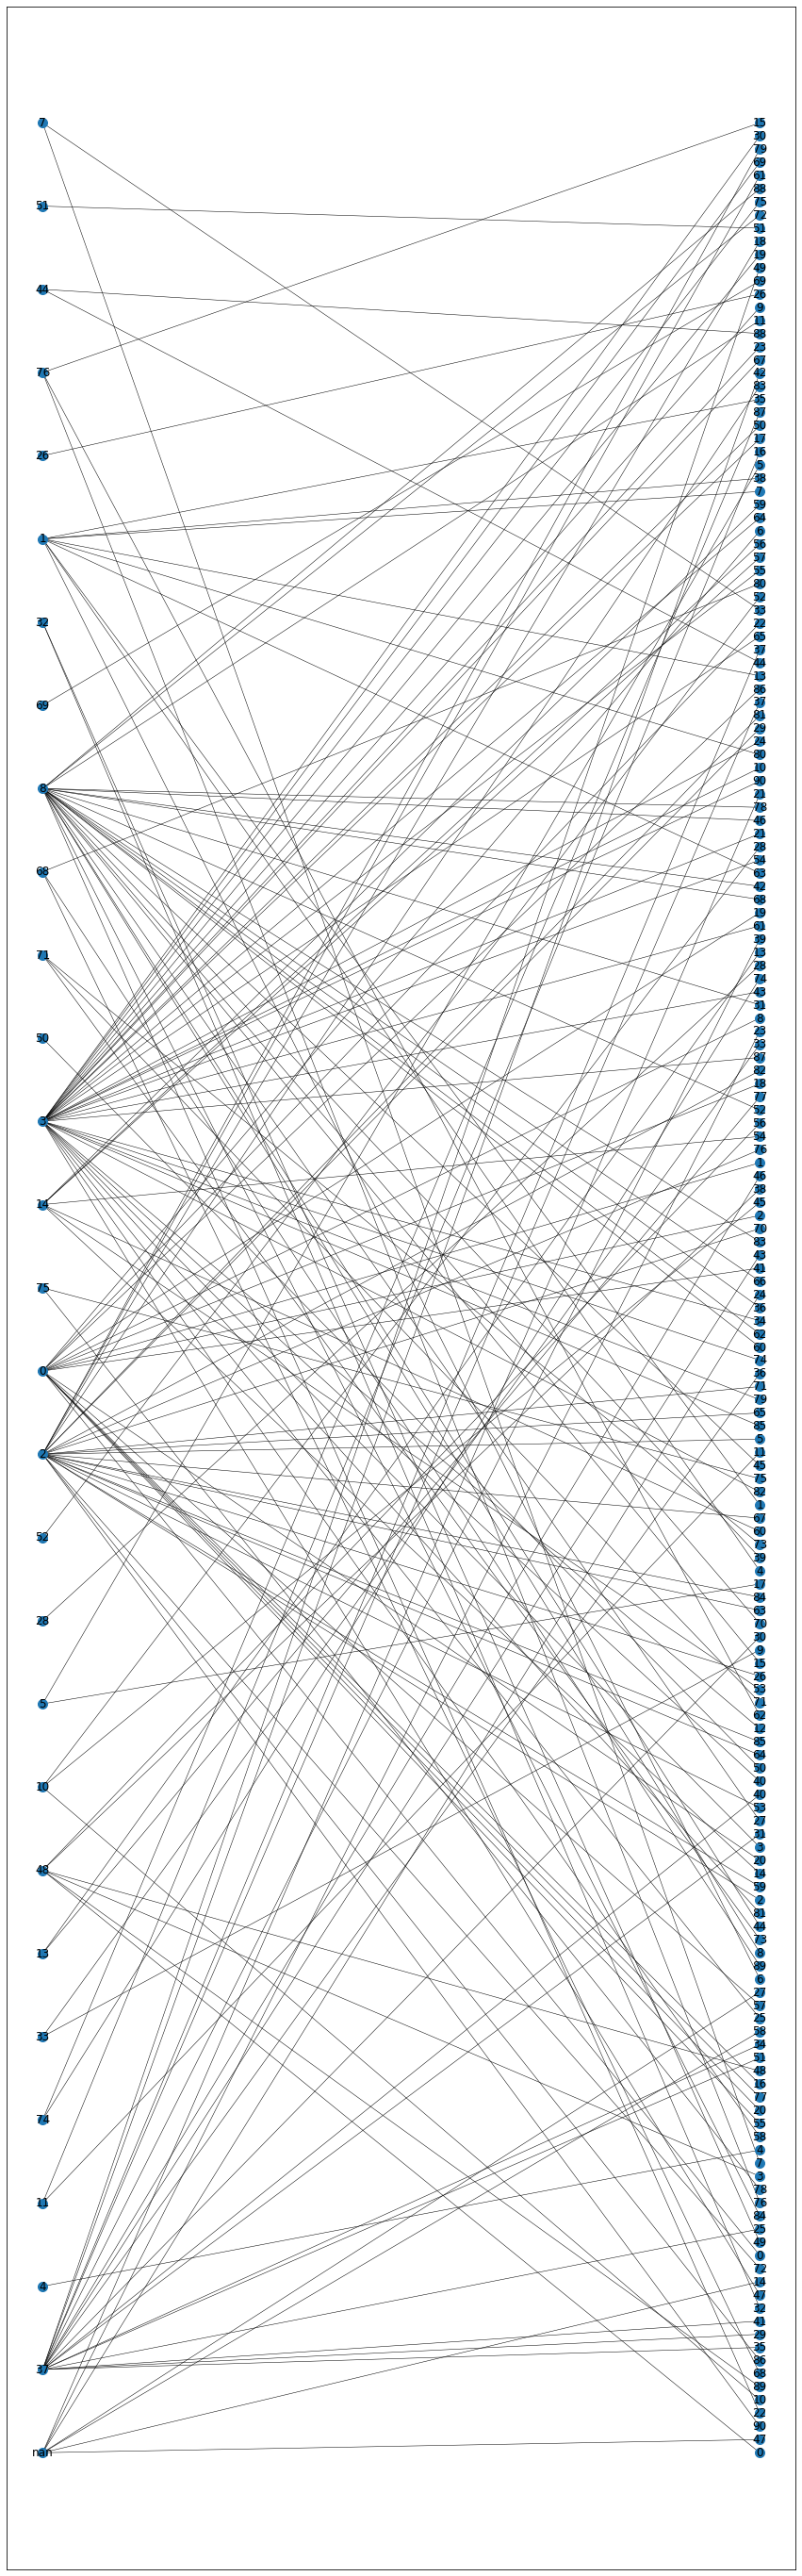

In [25]:
fig = plt.figure(figsize =(15, 50))
nx.draw_networkx(
    G,
    pos = nx.bipartite_layout(G,df["source"].unique(), align='vertical', center=None), 
    width = 0.5,
    scale=3,
    labels=labels, node_size=100)
plt.show()

In [26]:
df.drop(['id','url', 'top_img','authors','publish_date','canonical_link','meta_data'],axis=1, inplace=True)

In [27]:
df.isnull().sum()

title          0
text           0
source         8
movies       157
images        10
news_type      0
dtype: int64

In [28]:
(df.isnull().sum())/(df.shape[0])*100

title         0.000000
text          0.000000
source        4.395604
movies       86.263736
images        5.494505
news_type     0.000000
dtype: float64

In [29]:
df['contain_movies']=df['movies'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [30]:
df['contain_images']=df['images'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [31]:
df.drop(['movies','images'],axis=1,inplace=True)

In [32]:
df.head(2)

,title,text,source,news_type,contain_movies,contain_images
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1


## EDA

### Real Versus Fake News Source Analysis

#### Sources of Publising Real News

In [33]:
real_order=df[df['news_type']=='Real']['source'].value_counts().sort_values(ascending=False).index

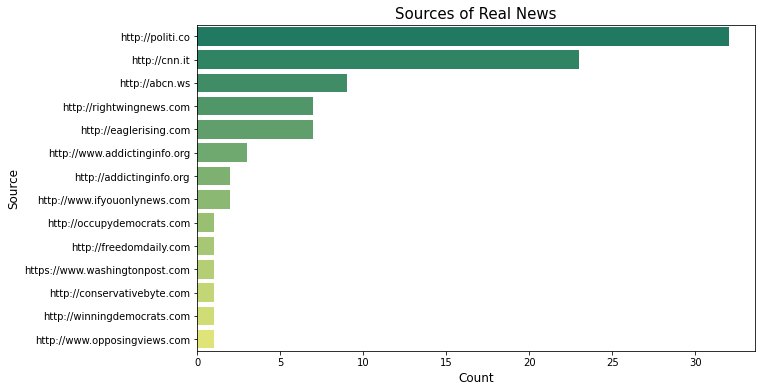

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=df[df['news_type']=='Real'],order=real_order,palette='summer')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Real News',fontsize=15)
plt.show()

#### Sources of Publishing Maximum Fake News

In [35]:
fake_order=df[df['news_type']=='Fake']['source'].value_counts().sort_values(ascending=False).index

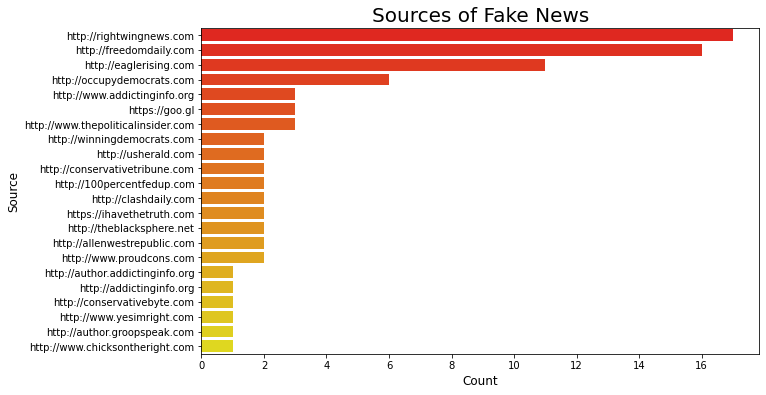

In [36]:
plt.figure(figsize=(10,6))
sns.countplot(y='source',data=df[df['news_type']=='Fake'],order=fake_order,palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=20)
plt.show()

#### Common Sources of Publishing Both Real and Fake News

In [37]:
new=[]
for x in df[df['news_type']=='Fake']['source'].unique():
    if x in df[df['news_type']=='Real']['source'].unique():
        new.append(x)
print(new)

['http://www.addictinginfo.org', 'http://eaglerising.com', 'http://conservativebyte.com', 'http://winningdemocrats.com', 'http://freedomdaily.com', 'http://occupydemocrats.com', 'http://rightwingnews.com', 'http://addictinginfo.org']


In [38]:
df['common']=df['source'].apply(lambda x: x if x in new else 0)

In [39]:
df1=df[df['common']!=0]

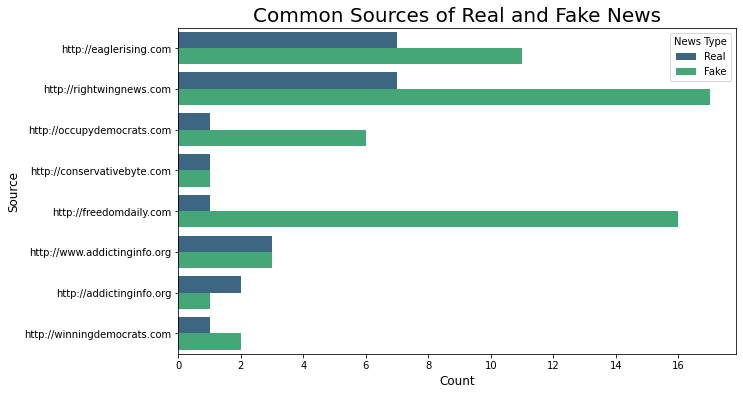

In [40]:
plt.figure(figsize=(10,6))
sns.countplot(y='common',data=df1,hue='news_type',palette='viridis')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Common Sources of Real and Fake News',fontsize=20)
plt.show()

#### Sources Including Movies in the News 

In [41]:
df.head(2)

,title,text,source,news_type,contain_movies,contain_images,common
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1,http://eaglerising.com
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1,0


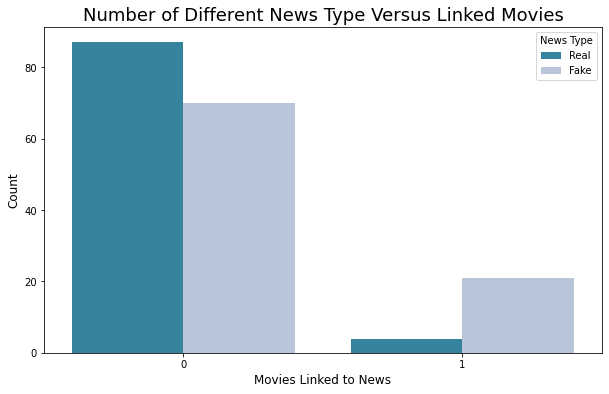

In [42]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_movies', data=df, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Movies Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Movies',fontsize=18)
plt.show()

#### Sources Including Images in the News 

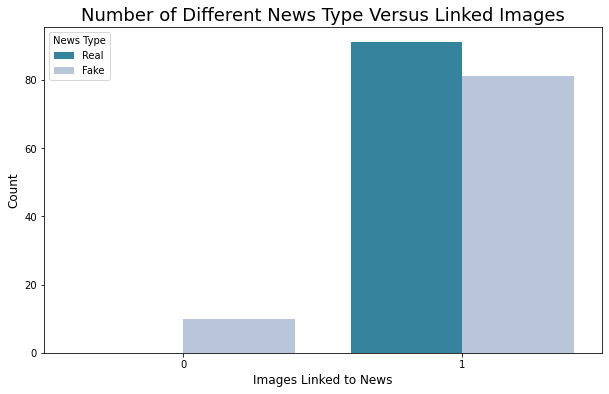

In [43]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_images', data=df, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Images Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='upper left', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Images',fontsize=18)
plt.show()

### Analysis of Title and Body of News Articles

#### Preprocessing Function

In [44]:
ps=PorterStemmer()
wst= WhitespaceTokenizer() 

##### 1. Converting text to lower case
def lower_func (x):
    return x.lower()


##### 2. Removing Numbers from the text corpus
def remove_number_func (x): 
    new=""
    for a in x:
        if a.isdigit()==False:
            new=new+a
    return new


##### 3. Removing punctuation 
def remove_punc_func(x):
    new=''
    for a in x:
        if a not in string.punctuation:
            new=new+a
    return new

##### 4. Removing special characters
def remove_spec_char_func(x):
    new=''
    for a in x:
        if (a.isalnum()==True) or (a==' '):
            new=new+a
    return(new)

##### 5. Removing english stopwords
def remove_stopwords(x):
    new=[]
    for a in x.split():
        if a not in stopwords.words('english'):
            new.append(a)
    return " ".join(new)

##### 6. Stemming words to root words
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

##### 7. Removing extra whitespaces 
def remove_whitespace_func(x):
    return(wst.tokenize(x))

def compose(f, g):
    return lambda x: f(g(x))

final=compose(compose(compose(compose(compose(compose(remove_whitespace_func,stem_func),remove_stopwords),remove_spec_char_func),remove_punc_func),remove_number_func),lower_func)

#### Analysis of News Title 

##### Fake News

In [45]:
df_fake=df[df['news_type']=='Fake']

In [46]:
cv1 = CountVectorizer(analyzer=final)
cv1.fit(df_fake['title'])
bow1=cv1.transform(df_fake['title'])

In [47]:
pd.DataFrame(bow1.todense()).shape

(91, 459)

In [48]:
new1=[]
for x in range(0,459):
    new1.append(cv1.get_feature_names()[x])

In [49]:
matrix1=pd.DataFrame(bow1.todense(),columns=new1)

In [50]:
sm1=[]
for x in new1:
    sm1.append(matrix1[x].sum())

In [51]:
trans1=matrix1.transpose()

In [52]:
trans1['sum']=sm1

In [53]:
top1=trans1.sort_values(by='sum', ascending=False).head(20)

##### Real News

In [54]:
df_real=df[df['news_type']=='Real']

In [55]:
cv2 = CountVectorizer(analyzer=final)
cv2.fit(df_real['title'])
bow2=cv2.transform(df_real['title'])

In [56]:
pd.DataFrame(bow2.todense()).shape

(91, 436)

In [57]:
new2=[]
for x in range(0,436):
    new2.append(cv2.get_feature_names()[x])

In [58]:
matrix2=pd.DataFrame(bow2.todense(),columns=new2)

In [59]:
sm2=[]
for x in new2:
    sm2.append(matrix2[x].sum())

In [60]:
trans2=matrix2.transpose()

In [61]:
trans2['sum']=sm2

In [62]:
top2=trans2.sort_values(by='sum', ascending=False).head(20)

##### Concatenation

In [63]:
top1.drop(list(range(0,91)),axis=1,inplace=True)

In [64]:
top1['type']=['Fake']*20

In [65]:
top2.drop(list(range(0,91)),axis=1,inplace=True)

In [66]:
top2['type']=['Real']*20

In [67]:
conc1=pd.concat([top1,top2])

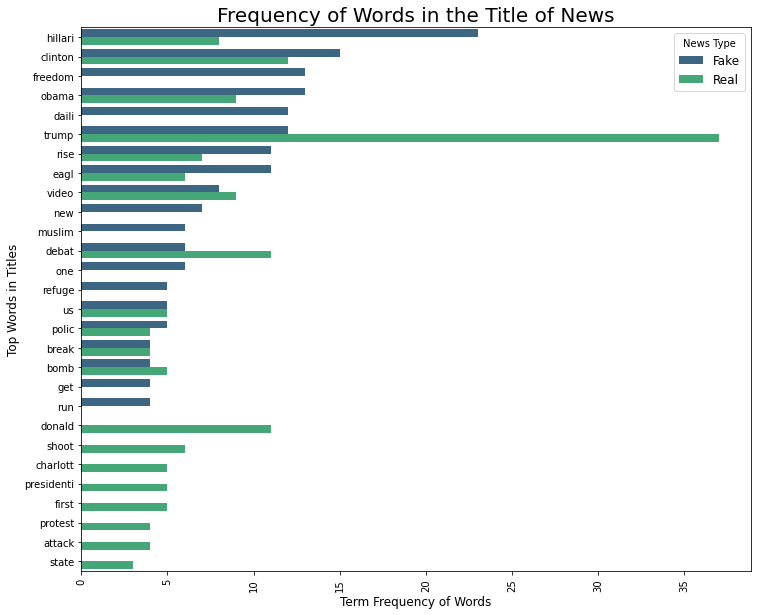

In [68]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc1.index,x='sum',data=conc1,hue='type',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Titles',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Title of News',fontsize=20)
plt.show()

#### Analysis of News Body

##### Fake News

In [69]:
cv3 = CountVectorizer(analyzer=final)
cv3.fit(df_fake['text'])
bow3=cv3.transform(df_fake['text'])

In [70]:
pd.DataFrame(bow3.todense()).shape

(91, 4958)

In [71]:
new3=[]
for x in range(0,4958):
    new3.append(cv3.get_feature_names()[x])

In [72]:
matrix3=pd.DataFrame(bow3.todense(),columns=new3)

In [73]:
sm3=[]
for x in new3:
    sm3.append(matrix3[x].sum())

In [74]:
trans3=matrix3.transpose()

In [75]:
trans3['sum']=sm3

In [76]:
top3=trans3.sort_values(by='sum', ascending=False).head(30)

##### Real News

In [77]:
cv4 = CountVectorizer(analyzer=final)
cv4.fit(df_real['text'])
bow4=cv4.transform(df_real['text'])

In [78]:
pd.DataFrame(bow4.todense()).shape

(91, 6529)

In [79]:
new4=[]
for x in range(0,6529):
    new4.append(cv4.get_feature_names()[x])

In [80]:
matrix4=pd.DataFrame(bow4.todense(),columns=new4)

In [81]:
sm4=[]
for x in new4:
    sm4.append(matrix4[x].sum())

In [82]:
trans4=matrix4.transpose()

In [83]:
trans4['sum']=sm4

In [84]:
top4=trans4.sort_values(by='sum', ascending=False).head(30)

##### Concatenation

In [85]:
top3.drop(list(range(0,91)),axis=1,inplace=True)

In [86]:
top3['type']=['Fake']*30

In [87]:
top4.drop(list(range(0,91)),axis=1,inplace=True)

In [88]:
top4['type']=['Real']*30

In [89]:
conc2=pd.concat([top3,top4])

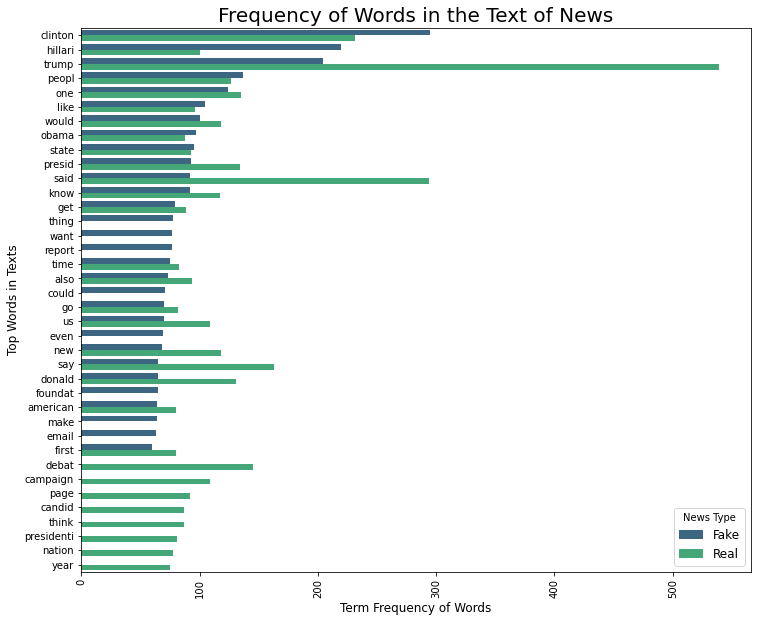

In [90]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc2.index,x='sum',data=conc2,hue='type',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Texts',fontsize=12)
plt.legend(title='News Type',fontsize=12,loc='lower right')
plt.title('Frequency of Words in the Text of News',fontsize=20)
plt.show()

#### Analysis of Title Length

In [91]:
df['title_length']=df['title'].apply(lambda x: len(x))

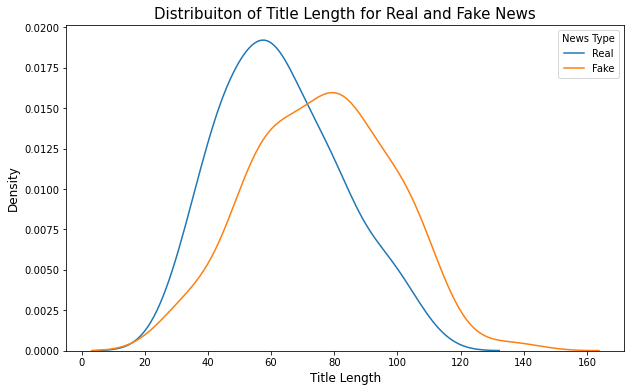

In [92]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['news_type']=='Real']['title_length'])
sns.kdeplot(df[df['news_type']=='Fake']['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Title Length for Real and Fake News',fontsize=15)
plt.show()

## Fake/Real News Classification

### Fake/Real News Detection Based on News Body

#### Splitting Data into Train and Test Datasets 

In [93]:
X1=df['text']
y1=df['news_type']

In [94]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

#### Random Forest Classifier with Text Preprocessing

In [95]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [96]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [97]:
predictions1=pp.predict(X1_test)

In [98]:
print(confusion_matrix(y1_test, predictions1))
print('\n')
print(classification_report(y1_test, predictions1))

[[19  7]
 [ 6 23]]


              precision    recall  f1-score   support

        Fake       0.76      0.73      0.75        26
        Real       0.77      0.79      0.78        29

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55



#### Random Forest Classifier Without Text Preprocessing

In [99]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [100]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [101]:
predictions2=pp.predict(X1_test)

In [102]:
print(confusion_matrix(y1_test, predictions2))
print('\n')
print(classification_report(y1_test, predictions2))

[[18  8]
 [ 6 23]]


              precision    recall  f1-score   support

        Fake       0.75      0.69      0.72        26
        Real       0.74      0.79      0.77        29

    accuracy                           0.75        55
   macro avg       0.75      0.74      0.74        55
weighted avg       0.75      0.75      0.74        55



#### Naive Bayes Classifier with Text Preprocessing

In [103]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [104]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [105]:
predictions3=pp.predict(X1_test)

In [106]:
print(confusion_matrix(y1_test, predictions3))
print('\n')
print(classification_report(y1_test, predictions3))

[[22  4]
 [13 16]]


              precision    recall  f1-score   support

        Fake       0.63      0.85      0.72        26
        Real       0.80      0.55      0.65        29

    accuracy                           0.69        55
   macro avg       0.71      0.70      0.69        55
weighted avg       0.72      0.69      0.69        55



#### Naive Bayes Classifier without Text Preprocessing

In [107]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [108]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [109]:
predictions4=pp.predict(X1_test)

In [110]:
print(confusion_matrix(y1_test, predictions4))
print('\n')
print(classification_report(y1_test, predictions4))

[[25  1]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.60      0.96      0.74        26
        Real       0.92      0.41      0.57        29

    accuracy                           0.67        55
   macro avg       0.76      0.69      0.65        55
weighted avg       0.77      0.67      0.65        55



#### Passive Aggressive Classifier with Text Preprocessing

In [111]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [112]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [113]:
predictions5=pp.predict(X1_test)

In [114]:
print(confusion_matrix(y1_test, predictions5))
print('\n')
print(classification_report(y1_test, predictions5))

[[21  5]
 [ 7 22]]


              precision    recall  f1-score   support

        Fake       0.75      0.81      0.78        26
        Real       0.81      0.76      0.79        29

    accuracy                           0.78        55
   macro avg       0.78      0.78      0.78        55
weighted avg       0.78      0.78      0.78        55



#### Passive Aggressive Classifier without Text Preprocessing

In [115]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [116]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [117]:
predictions6=pp.predict(X1_test)

In [118]:
print(confusion_matrix(y1_test, predictions6))
print('\n')
print(classification_report(y1_test, predictions6))

[[21  5]
 [ 4 25]]


              precision    recall  f1-score   support

        Fake       0.84      0.81      0.82        26
        Real       0.83      0.86      0.85        29

    accuracy                           0.84        55
   macro avg       0.84      0.83      0.84        55
weighted avg       0.84      0.84      0.84        55



### Fake/Real News Detection Based on News Title

#### Splitting Data into Train and Test Datasets 

In [119]:
X2=df['title']
y2=df['news_type']

In [120]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

#### Random Forest Classifier with Text Preprocessing

In [121]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [122]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [123]:
predictions7=pp.predict(X2_test)

In [124]:
print(confusion_matrix(y2_test, predictions7))
print('\n')
print(classification_report(y2_test, predictions7))

[[21  5]
 [11 18]]


              precision    recall  f1-score   support

        Fake       0.66      0.81      0.72        26
        Real       0.78      0.62      0.69        29

    accuracy                           0.71        55
   macro avg       0.72      0.71      0.71        55
weighted avg       0.72      0.71      0.71        55



#### Random Forest Classifier without Text Preprocessing

In [125]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [126]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [127]:
predictions8=pp.predict(X2_test)

In [128]:
print(confusion_matrix(y2_test, predictions8))
print('\n')
print(classification_report(y2_test, predictions8))

[[13 13]
 [ 8 21]]


              precision    recall  f1-score   support

        Fake       0.62      0.50      0.55        26
        Real       0.62      0.72      0.67        29

    accuracy                           0.62        55
   macro avg       0.62      0.61      0.61        55
weighted avg       0.62      0.62      0.61        55



#### Naive Bayes Classifier with Text Preprocessing

In [129]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [130]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [131]:
predictions9=pp.predict(X2_test)

In [132]:
print(confusion_matrix(y2_test, predictions9))
print('\n')
print(classification_report(y2_test, predictions9))

[[21  5]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.55      0.81      0.66        26
        Real       0.71      0.41      0.52        29

    accuracy                           0.60        55
   macro avg       0.63      0.61      0.59        55
weighted avg       0.63      0.60      0.59        55



#### Naive Bayes Classifier without Text Preprocessing

In [133]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [134]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [135]:
predictions10=pp.predict(X2_test)

In [136]:
print(confusion_matrix(y2_test, predictions10))
print('\n')
print(classification_report(y2_test, predictions10))

[[22  4]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.54      0.85      0.66        26
        Real       0.71      0.34      0.47        29

    accuracy                           0.58        55
   macro avg       0.63      0.60      0.56        55
weighted avg       0.63      0.58      0.56        55



#### Passive Aggressive Classifier with Text Preprocessing

In [137]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [138]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [139]:
predictions11=pp.predict(X2_test)

In [140]:
print(confusion_matrix(y2_test, predictions11))
print('\n')
print(classification_report(y2_test, predictions11))

[[20  6]
 [15 14]]


              precision    recall  f1-score   support

        Fake       0.57      0.77      0.66        26
        Real       0.70      0.48      0.57        29

    accuracy                           0.62        55
   macro avg       0.64      0.63      0.61        55
weighted avg       0.64      0.62      0.61        55



#### Passive Aggressive Classifier without Text Preprocessing

In [141]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [142]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [143]:
predictions12=pp.predict(X2_test)

In [144]:
print(confusion_matrix(y2_test, predictions12))
print('\n')
print(classification_report(y2_test, predictions12))

[[19  7]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.53      0.73      0.61        26
        Real       0.63      0.41      0.50        29

    accuracy                           0.56        55
   macro avg       0.58      0.57      0.56        55
weighted avg       0.58      0.56      0.55        55



### Fake/Real News Detection Based on Both Body and Title of News 

#### Splitting Data into Train and Test Datasets 

In [145]:
df['title_text']=df['title']+': ' +df['text']

In [146]:
X3=df['title_text']
y3=df['news_type']

In [147]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

#### Random Forest Classifier with Text Preprocessing

In [148]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [149]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [150]:
predictions13=pp.predict(X3_test)

In [151]:
print(confusion_matrix(y3_test, predictions13))
print('\n')
print(classification_report(y3_test, predictions13))

[[20  6]
 [ 7 22]]


              precision    recall  f1-score   support

        Fake       0.74      0.77      0.75        26
        Real       0.79      0.76      0.77        29

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55



#### Random Forest Classifier without Text Preprocessing

In [152]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [153]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [154]:
predictions14=pp.predict(X3_test)

In [155]:
print(confusion_matrix(y3_test, predictions14))
print('\n')
print(classification_report(y3_test, predictions14))

[[18  8]
 [ 3 26]]


              precision    recall  f1-score   support

        Fake       0.86      0.69      0.77        26
        Real       0.76      0.90      0.83        29

    accuracy                           0.80        55
   macro avg       0.81      0.79      0.80        55
weighted avg       0.81      0.80      0.80        55



#### Naive Bayes Classifier with Text Preprocessing

In [156]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [157]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [158]:
predictions15=pp.predict(X3_test)

In [159]:
print(confusion_matrix(y3_test, predictions15))
print('\n')
print(classification_report(y3_test, predictions15))

[[22  4]
 [15 14]]


              precision    recall  f1-score   support

        Fake       0.59      0.85      0.70        26
        Real       0.78      0.48      0.60        29

    accuracy                           0.65        55
   macro avg       0.69      0.66      0.65        55
weighted avg       0.69      0.65      0.64        55



#### Naive Bayes Classifier without Text Preprocessing

In [160]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [161]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [162]:
predictions16=pp.predict(X3_test)

In [163]:
print(confusion_matrix(y3_test, predictions16))
print('\n')
print(classification_report(y3_test, predictions16))

[[25  1]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.57      0.96      0.71        26
        Real       0.91      0.34      0.50        29

    accuracy                           0.64        55
   macro avg       0.74      0.65      0.61        55
weighted avg       0.75      0.64      0.60        55



#### Passive Aggressive Classifier withText Preprocessing

In [164]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [165]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7df8ecc4db90>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [166]:
predictions17=pp.predict(X3_test)

In [167]:
print(confusion_matrix(y3_test, predictions17))
print('\n')
print(classification_report(y3_test, predictions17))

[[20  6]
 [ 8 21]]


              precision    recall  f1-score   support

        Fake       0.71      0.77      0.74        26
        Real       0.78      0.72      0.75        29

    accuracy                           0.75        55
   macro avg       0.75      0.75      0.75        55
weighted avg       0.75      0.75      0.75        55



#### Passive Aggressive Classifier without Text Preprocessing

In [168]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [169]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [170]:
predictions18=pp.predict(X3_test)

In [171]:
print(confusion_matrix(y3_test, predictions18))
print('\n')
print(classification_report(y3_test, predictions18))

[[23  3]
 [ 3 26]]


              precision    recall  f1-score   support

        Fake       0.88      0.88      0.88        26
        Real       0.90      0.90      0.90        29

    accuracy                           0.89        55
   macro avg       0.89      0.89      0.89        55
weighted avg       0.89      0.89      0.89        55



In [172]:
print('Text_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions1)))
print('Text_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions2)))
print('Text_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions3)))
print('Text_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions4)))
print('Text_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions5)))
print('Text_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions6)))
print('\n')
print('Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions7)))
print('Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions8)))
print('Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions9)))
print('Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions10)))
print('Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions11)))
print('Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions12)))
print('\n')
print('Text&Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions13)))
print('Text&Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions14)))
print('Text&Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions15)))
print('Text&Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions16)))
print('Text&Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions17)))
print('Text&Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions18)))

Text_Random Forest Classifier_With Text Preprocessing:  76.0
Text_Random Forest Classifier_Without Text Preprocessing:  75.0
Text_Naive Bayes Classifier_With Text Preprocessing:  69.0
Text_Naive Bayes Classifier_Without Text Preprocessing:  67.0
Text_Passive Aggressive Classifier_With Text Preprocessing:  78.0
Text_Passive Aggressive Classifier_Without Text Preprocessing:  84.0


Title_Random Forest Classifier_With Text Preprocessing:  71.0
Title_Random Forest Classifier_Without Text Preprocessing:  62.0
Title_Naive Bayes Classifier_With Text Preprocessing:  60.0
Title_Naive Bayes Classifier_Without Text Preprocessing:  58.0
Title_Passive Aggressive Classifier_With Text Preprocessing:  62.0
Title_Passive Aggressive Classifier_Without Text Preprocessing:  56.0


Text&Title_Random Forest Classifier_With Text Preprocessing:  76.0
Text&Title_Random Forest Classifier_Without Text Preprocessing:  80.0
Text&Title_Naive Bayes Classifier_With Text Preprocessing:  65.0
Text&Title_Naive Bayes Cla